In [1]:
import numpy as np
import sys
sys.path.append("/cluster/users/tom/git/neon_blink_detection/")

from training.video_loader import video_loader
from src.helper import OfParams
from pathlib import Path

video_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

of_params = OfParams()

clip_names = np.array(
    [

        "1290-2023-01-31-13-22-58-3ef10981",
        "1002-2022-12-14-11-43-58-23e05b8c",
    ]
)


In [2]:
rec = video_loader(of_params)
from utils import resize_images, rotate_images


In [3]:
ts, images_left, images_right = rec._get_frames(clip_names[0], convert_to_gray=True)
blink_df = rec._load_gt_labels(clip_names[0])


In [4]:
x = np.linspace(0, 64, 65)

x = np.linspace(0, 63, 64, dtype=np.float32)
y = np.linspace(0, 63, 64, dtype=np.float32)
xx, yy = np.meshgrid(x, y) 
p_grid = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

In [5]:
p_grid

array([[ 0.,  0.],
       [ 1.,  0.],
       [ 2.,  0.],
       ...,
       [61., 63.],
       [62., 63.],
       [63., 63.]], dtype=float32)

In [248]:
import scipy
from scipy.ndimage import rotate

blink_ts = blink_df[blink_df["label"]=="onset"].iloc[6, :]["start_ts"]
blink_on_idx = int(np.where(ts == blink_ts)[0])
blink_ts = blink_df[blink_df["label"]=="offset"].iloc[5, :]["end_ts"]
blink_off_idx = int(np.where(ts == blink_ts)[0])

of_params.grid_size = 15
of_params.n_layers = 7
of_params.layer_interval = 5
of_params.window_size = 15

print(blink_on_idx)
print(blink_off_idx)

images = images_left[blink_on_idx-30:blink_off_idx+30, :, :]
images_left_rot = np.zeros(images_left.shape)

for ifr in range(0, images_left.shape[0]):
    images_left_rot[ifr, :, :] = rotate(images_left[ifr, :, :], 30, reshape=False, mode="nearest")

images_rot = images_left_rot[blink_on_idx-30:blink_off_idx+30, :, :]

feature_array, grid = rec._compute_optical_flow(of_params, images_left, images_right)
feature_array_rot, grid = rec._compute_optical_flow(of_params, images_left_rot, images_right)

feature_array = feature_array[blink_on_idx-30:blink_off_idx+30, :, :]
feature_array_rot = feature_array_rot[blink_on_idx-30:blink_off_idx+30, :, :]

zz = np.zeros([64, 64, feature_array.shape[0]])
zz_rot = np.zeros([64, 64, feature_array.shape[0]])
frame_counter = 0

zz = scipy.interpolate.griddata(grid, feature_array[:, 0:225, 1].transpose(), p_grid, method="linear")

zz = zz.reshape(64, 64, zz.shape[1])

zz_rot = scipy.interpolate.griddata(grid, feature_array_rot[:, 0:225, 1].transpose(), p_grid, method="linear")

zz_rot = zz_rot.reshape(64, 64, zz_rot.shape[1])

# for iframe in range(0, feature_array.shape[0]):
#     a=scipy.interpolate.griddata(grid, feature_array[iframe, 0:225, 1], p_grid, method="linear")
#     b=scipy.interpolate.griddata(grid, feature_array_rot[iframe, 0:225, 1], p_grid, method="linear")
#     count = 0
#     for ix in range(0, 64):
#         for iy in range(0, 64):
#             zz[ix, iy, frame_counter] = a[count]
#             zz_rot[ix, iy, frame_counter] = b[count]
#             count += 1
    
#     frame_counter += 1



1183
1235


In [100]:
img = np.zeros([64, 64, 5])
for i in range(0, 5):
    a=scipy.interpolate.griddata(grid, feature_array[100+i, 0:225, 1], p_grid, method="linear")
    img[:, :, i] = a.reshape(64,64)

In [192]:
import typing as T

def zoom_center(img, zoom_factor: int, shift: T.List[int]):

    y_size = img.shape[0]
    x_size = img.shape[1]
    
    img = scipy.ndimage.shift(img, [shift[0], shift[1], 0], mode="nearest")

    # define new boundaries
    x1 = int(0.5*x_size*(1-1/zoom_factor)) 
    x2 = int(x_size-0.5*x_size*(1-1/zoom_factor))
    y1 = int(0.5*y_size*(1-1/zoom_factor))
    y2 = int(y_size-0.5*y_size*(1-1/zoom_factor))

    # first crop image then scale
    img_cropped = img[y1:y2,x1:x2, :]

    
    return cv2.resize(img_cropped, None, fx=zoom_factor, fy=zoom_factor)


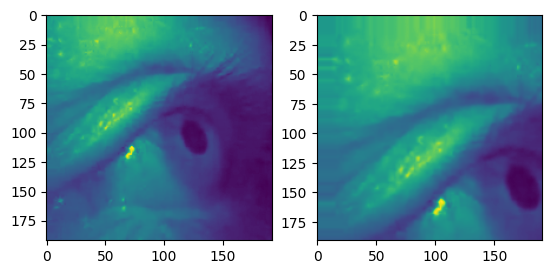

In [202]:

i = 10
img_zoom = zoom_center(images_left[i, :, :, :], zoom_factor=1.3, shift=[30, 30])

f, ax = plt.subplots(1,2)
ax[0].imshow(images_left[i, :, :, 0])
ax[1].imshow(img_zoom)


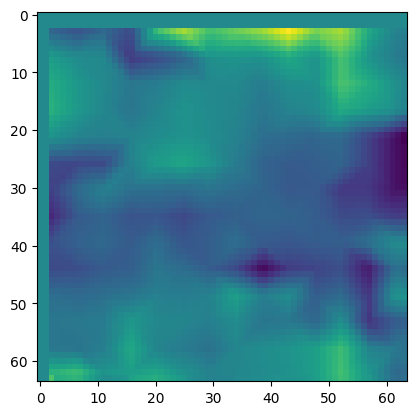

In [167]:
plt.imshow()

In [249]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = images

fig, axs = plt.subplots(2,2)
im0 = axs[0, 0].imshow(video[0,:,:,:], cmap='gray')
axs[0, 0].axis("off")

im1 = axs[0, 1].imshow(zz[:,:,0], vmin=-10, vmax=10)
axs[0, 1].axis("off")

video1 = images_rot

im2 = axs[1, 0].imshow(video1[0,:,:,:], cmap='gray')
axs[1, 0].axis("off")

im3 = axs[1, 1].imshow(zz_rot[:,:,0], vmin=-10, vmax=10)
axs[1, 1].axis("off")

plt.close() # this is required to not display the generated image

def init():
    im0.set_data(video[0,:,:,:])
    im1.set_data(zz[:,:,0])
    im2.set_data(video1[0,:,:,:])
    im3.set_data(zz_rot[:,:,0])

def animate(i):
    im0.set_data(video[i,:,:,:])
    im1.set_data(zz[:,:,i])
    im2.set_data(video1[i,:,:,:])
    im3.set_data(zz_rot[:,:,i])
    return im0, im1, im2, im3

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

In [93]:
zz_rot-zz

array([[[ 2.70834446e-01,  5.56435585e-02,  5.46155453e-01, ...,
          7.64540195e-01,  1.80217218e+00,  1.58963203e-01],
        [ 2.86404311e-01,  1.69134031e-01,  4.72451750e-01, ...,
          4.89966271e-01,  1.41420834e+00,  1.44984142e-01],
        [ 3.01974176e-01,  2.82624503e-01,  3.98748047e-01, ...,
          2.15392346e-01,  1.02624450e+00,  1.31005080e-01],
        ...,
        [ 8.10042511e-02,  1.08748911e-01, -2.82752055e-02, ...,
         -3.44151140e-01, -3.38893724e-01, -3.69712768e-01],
        [ 5.69477803e-02,  9.34017489e-02, -2.71811179e-02, ...,
         -8.13031999e-02, -7.27653984e-02, -2.42969154e-01],
        [ 3.28913096e-02,  7.80545865e-02, -2.60870304e-02, ...,
          1.81544741e-01,  1.93362927e-01, -1.16225540e-01]],

       [[ 1.97271872e-01,  1.79314779e-02,  4.19447264e-01, ...,
          6.59115453e-01,  1.46452512e+00, -5.87633676e-02],
        [ 2.12841737e-01,  1.31421950e-01,  3.45743561e-01, ...,
          3.84541529e-01,  1.07656127e

In [94]:
zz.shape

(64, 64, 112)

In [227]:
10*10

100

In [238]:
timestamps = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16])

In [248]:
np.where(np.diff(timestamps)>1)[0][0]

9

In [249]:
timestamps[0:9]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [91]:
scipy.interpolate.griddata(grid, feature_array[iframe, 0:225, 1])

TypeError: griddata() missing 1 required positional argument: 'xi'

In [246]:
# feature_array, grid = rec._compute_optical_flow(of_params, images_left, images_right)
# feature_array_rot, grid = rec._compute_optical_flow(of_params, images_left_rot, images_right)






(4096, 112)

In [244]:
feature_array[:, 0:225, 1].transpose().shape

(225, 112)

In [178]:
img = images_left[:, :, :, 0].transpose((1, 2, 0))
img = np.concatenate((img, images_left[:, :, :, 0].transpose((1, 2, 0))), axis=2)

img = img.reshape((192, 192, 2, 2604))

In [179]:
img.shape

(192, 192, 2, 2604)

In [18]:
img.shape

(192, 192, 2604)

In [111]:

def _shift_image(img, y_shift = 0, x_shift = 0):
    """ Shift image by y_shift (positive: up, negative: down) and x_shift (positive: right, negative: left) pixels. 
    img: HxWxNxM array (where N and M are optional dimensions)
    """

    if np.sign(x_shift) == 1:
        x_left = 0
        x_right = x_shift
    else:
        x_left = -x_shift
        x_right = 0

    if np.sign(y_shift) == 1:
        y_up = y_shift
        y_down = 0
    else:
        y_up = 0
        y_down = -y_shift

    if img.ndim == 2:
        return np.pad(img, ((y_down, y_up), (x_right, x_left)), mode="linear_ramp")[y_up:y_up+img.shape[0], x_left:img.shape[0]+x_left]
    
    elif img.ndim == 3:
        return np.pad(img, ((y_down, y_up), (x_right, x_left), (0, 0)), mode="linear_ramp")[y_up:y_up+img.shape[0], x_left:img.shape[0]+x_left, :]

    elif img.ndim == 4:
        return np.pad(img, ((y_down, y_up), (x_right, x_left), (0, 0), (0, 0)), mode="linear_ramp")[y_up:y_up+img.shape[0], x_left:img.shape[0]+x_left, :, :]

    else: 
        raise ValueError("Image must be 2D, 3D or 4D array")




In [119]:
img.ndim

3

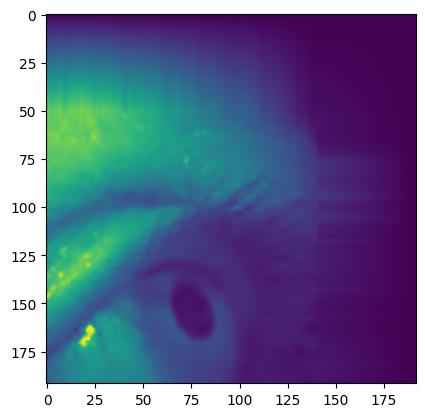

In [167]:
img.shape

(192, 192, 2604)

(192, 192)

In [130]:
img.resize(img, 250,)

SyntaxError: unmatched ')' (865448470.py, line 1)

In [127]:
np.ones((200,200)).shape

(200, 200)

In [132]:
w,h = img.size

TypeError: cannot unpack non-iterable int object

In [207]:
import typing as T
def _zoom_and_shift(
    self, img: np.ndarray, zoom_factor: np.float32, shift: T.List[int]
):

    size = img.shape

    img = self._shift_image(img, y_shift=shift[0], x_shift=shift[1])

    lim1 = int(0.5 * size[0] * (1 - 1 / zoom_factor))
    lim2 = int(size[0] - 0.5 * size[0] * (1 - 1 / zoom_factor))

    img_cropped = img[lim1:lim2, lim1:lim2, :, :]

    img_cropped = img_cropped.reshape(
        img_cropped.shape[0],
        img_cropped.shape[1],
        size[2] * size[3],
    )

    # Split in chunks as cv2 cannot seem to handle large images
    split_idc = list(range(500, img_cropped.shape[-1], 500))
    split_img = np.split(img_cropped, split_idc, axis=2)

    img_list = [
        cv2.resize(img, None, fx=zoom_factor, fy=zoom_factor) for img in split_img
    ]

    img_resized = np.concatenate(img_list, axis=2)
    img_resized = img_resized.reshape(size)

    return img_resized

In [208]:
img.shape

(192, 192, 2, 2604)

In [195]:
split_img[0]

array([], shape=(192, 192, 0), dtype=uint8)